Segmentation<br>
Convolution + Deconvolution<Br>
input is image(color image), output is label data(gray image)<br>


In [1]:
from PIL import Image
import cPickle as pkl
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.training import moving_averages
import tensorflow as tf
import glob
import os
import math

%matplotlib inline

In [2]:
# https://github.com/alexgkendall/SegNet-Tutorial
!ls /data/SegNet-Tutorial/CamVid/

test  test.txt	testannot  train  train.txt  trainannot  val  val.txt  valannot


In [3]:
# Location of the files
camvidpath = '/data/SegNet-Tutorial/CamVid/'

# Training data
path1 = camvidpath + 'train/'
path2 = camvidpath + 'trainannot/'
trainimglist = glob.glob(path1 + '/*.png')
trainannotlist = glob.glob(path2 + '/*.png')
print ("%d train images" % (len(trainimglist)))
print ("%d train annotations" % (len(trainannotlist)))

# Test data
path1 = camvidpath + 'test/'
path2 = camvidpath + 'testannot/'
testimglist = glob.glob(path1 + '/*.png')
testannotlist = glob.glob(path2 + '/*.png')
print ("%d test images" % (len(testimglist)))
print ("%d test annotations" % (len(testannotlist)))

367 train images
367 train annotations
233 test images
233 test annotations


In [4]:
height = 128
width = 128
nrclass = 22
trainData = None
trainLabel = None
trainLabelOneHot = None
trainlen = len(trainimglist)
testData = None
testLabel = None
testLabelOneHot = None
testlen = len(testimglist)

def DenseToOneHot(labels_dense, num_classes):
    # Convert class labels from scalars to one-hot vectors.
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    
    return labels_one_hot

In [5]:
# Train data process
for (f1, f2, i) in zip(trainimglist, trainannotlist, range(trainlen)):
    # Train image
    img1 = Image.open(f1)
    img1 = img1.resize((height, width))
    rgb = np.array(img1).reshape(1, height, width, 3)
    
    # Train label
    img2 = Image.open(f2)
    img2 = img2.resize((height, width), Image.NEAREST)
    label = np.array(img2).reshape(1, height, width, 1)
    
    # Stack images and labels
    if i==0:
        trainData = rgb
        trainLabel = label
    else:
        trainData = np.concatenate((trainData, rgb), axis = 0)
        trainLabel = np.concatenate((trainLabel, label), axis = 0)
        
ntrain = len(trainData)

# Onehot-coded label
trainLabelOneHot = np.zeros((trainLabel.shape[0], trainLabel.shape[1], trainLabel.shape[2], nrclass))
for row in range(height):
    for col in range(width):
        single = trainLabel[:, row, col, 0]
        oneHot = DenseToOneHot(single, nrclass) # (367, ) -> (367, 22)
        trainLabelOneHot[:, row, col, :] = oneHot

print ("Train data process done.")

Train data process done.


In [6]:
# Test data process
for (f1, f2, i) in zip(testimglist, testannotlist, range(testlen)):
    # Train image
    img1 = Image.open(f1)
    img1 = img1.resize((height, width))
    rgb = np.array(img1).reshape(1, height, width, 3)
    
    # Train label
    img2 = Image.open(f2)
    img2 = img2.resize((height, width), Image.NEAREST)
    label = np.array(img2).reshape(1, height, width, 1)
    
    # Stack images and labels
    if i==0:
        testData = rgb
        testLabel = label
    else:
        testData = np.concatenate((testData, rgb), axis = 0)
        testLabel = np.concatenate((testLabel, label), axis = 0)
        
ntest = len(testData)

# Onehot-coded label
testLabelOneHot = np.zeros((testLabel.shape[0], testLabel.shape[1], testLabel.shape[2], nrclass))
for row in range(height):
    for col in range(width):
        single = testLabel[:, row, col, 0]
        oneHot = DenseToOneHot(single, nrclass) # (367, ) -> (367, 22)
        testLabelOneHot[:, row, col, :] = oneHot

print ("Test data process done.")

Test data process done.


In [7]:
def drawImageSet(trainIndex):
    plt.figure(1)
    plt.imshow(trainData[trainIndex])
    plt.title("Image")
    plt.draw()

    tmp = trainLabel[trainIndex].reshape(trainLabel[trainIndex].shape[0], trainLabel[trainIndex].shape[1])
    print (str(tmp.shape) + ", max: " + str(tmp.max()))

    plt.figure(2)
    plt.matshow(tmp, cmap=plt.get_cmap('gray'))
    plt.title("Label")
    plt.draw()

(128, 128), max: 11


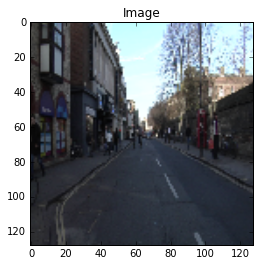

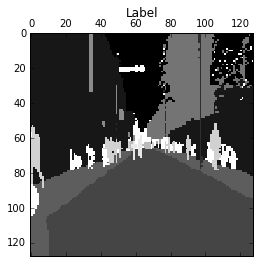

In [8]:
drawImageSet(0)

In [9]:
print ("Shape of 'trainData' is %s" % (trainData.shape,))
print ("Shape of 'trainLabel' is %s" % (trainLabel.shape,))
print ("Shape of 'trainLabelOneHot' is %s" % (trainLabelOneHot.shape,))
print ("Shape of 'testData' is %s" % (testData.shape,))
print ("Shape of 'testLabel' is %s" % (testLabel.shape,))
print ("Shape of 'testLabelOneHot' is %s" % (testLabelOneHot.shape,))

Shape of 'trainData' is (367, 128, 128, 3)
Shape of 'trainLabel' is (367, 128, 128, 1)
Shape of 'trainLabelOneHot' is (367, 128, 128, 22)
Shape of 'testData' is (233, 128, 128, 3)
Shape of 'testLabel' is (233, 128, 128, 1)
Shape of 'testLabelOneHot' is (233, 128, 128, 22)


In [10]:
# Define functions
x = tf.placeholder(tf.float32, [None, height, width, 3])
y = tf.placeholder(tf.float32, [None, height, width, nrclass])
keepprob = tf.placeholder(tf.float32)

# Kernels
ksize = 7
fsize = 64
initstdev = 0.1
initfun = tf.random_normal_initializer(mean=0.0, stddev=initstdev)

# initfun = None
weights = {
    # encoding
    # convolution [width, height, input color depth, output color depth]
    'ce1': tf.get_variable("ce1", shape = [ksize, ksize, 3, fsize], initializer = initfun), 
    'ce2': tf.get_variable("ce2", shape = [ksize, ksize, fsize, fsize], initializer = initfun), 
    'ce3': tf.get_variable("ce3", shape = [ksize, ksize, fsize, fsize], initializer = initfun), 
    'ce4': tf.get_variable("ce4", shape = [ksize, ksize, fsize, fsize], initializer = initfun), 
    # decoding
    'cd4': tf.get_variable("cd4", shape = [ksize, ksize, fsize, fsize], initializer = initfun), 
    'cd3': tf.get_variable("cd3", shape = [ksize, ksize, fsize, fsize], initializer = initfun), 
    'cd2': tf.get_variable("cd2", shape = [ksize, ksize, fsize, fsize], initializer = initfun), 
    'cd1': tf.get_variable("cd1", shape = [ksize, ksize, fsize, fsize], initializer = initfun), 
    'dense_inner_prod': tf.get_variable("dense_inner_prod", shape= [1, 1, fsize, nrclass], initializer = initfun)
}

In [11]:
biases = {
    # encoding
    'be1': tf.get_variable("be1", shape = [fsize], initializer = tf.constant_initializer(value=0.)), 
    'be2': tf.get_variable("be2", shape = [fsize], initializer = tf.constant_initializer(value=0.)), 
    'be3': tf.get_variable("be3", shape = [fsize], initializer = tf.constant_initializer(value=0.)), 
    'be4': tf.get_variable("be4", shape = [fsize], initializer = tf.constant_initializer(value=0.)), 
    # decoding
    'bd4': tf.get_variable("bd4", shape = [fsize], initializer = tf.constant_initializer(value=0.)), 
    'bd3': tf.get_variable("bd3", shape = [fsize], initializer = tf.constant_initializer(value=0.)), 
    'bd2': tf.get_variable("bd2", shape = [fsize], initializer = tf.constant_initializer(value=0.)), 
    'bd1': tf.get_variable("bd1", shape = [fsize], initializer = tf.constant_initializer(value=0.)), 
}

In [12]:
def conv(_X, _w, _b, _keepprob, use_bias):
    
    encoder = tf.nn.conv2d(_X, _w, strides=[1, 1, 1, 1], padding='SAME')
    if use_bias:
        encoder = tf.nn.bias_add(encoder, _b)
    mean, var = tf.nn.moments(encoder, [0, 1, 2])
    # https://www.tensorflow.org/versions/r0.10/api_docs/python/nn.html#batch_normalization
    encoder = tf.nn.batch_normalization(encoder, mean, var, 0, 1, 0.0001)
    encoder = tf.nn.relu(encoder)
    encoder = tf.nn.max_pool(encoder, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    encoder = tf.nn.dropout(encoder, _keepprob)
    
    return encoder

In [13]:
# https://github.com/tensorflow/tensorflow/issues/2169
def unpool(value, name='unpool'):
    """N-dimensional version of the unpooling operation from
    https://www.robots.ox.ac.uk/~vgg/rg/papers/Dosovitskiy_Learning_to_Generate_2015_CVPR_paper.pdf

    :param value: A Tensor of shape [b, d0, d1, ..., dn, ch]
    :return: A Tensor of shape [b, 2*d0, 2*d1, ..., 2*dn, ch]
    """
    with tf.name_scope(name) as scope:
        sh = value.get_shape().as_list()
        dim = len(sh[1:-1])
        out = (tf.reshape(value, [-1] + sh[-dim:]))
        for i in range(dim, 0, -1):
            out = tf.concat(i, [out, tf.zeros_like(out)])
        out_size = [-1] + [s * 2 for s in sh[1:-1]] + [sh[-1]]
        out = tf.reshape(out, out_size, name=scope)
    return out


def pool(value, name='pool'):
    """Downsampling operation.
    :param value: A Tensor of shape [b, d0, d1, ..., dn, ch]
    :return: A Tensor of shape [b, d0/2, d1/2, ..., dn/2, ch]
    """
    with tf.name_scope(name) as scope:
        sh = value.get_shape().as_list()
        out = value
        for sh_i in sh[1:-1]:
            assert sh_i % 2 == 0
        for i in range(len(sh[1:-1])):
            out = tf.reshape(out, (-1, 2, np.prod(sh[i + 2:])))
            out = out[:, 0, :]
        out_size = [-1] + [int(math.ceil(s / 2)) for s in sh[1:-1]] + [sh[-1]]
        out = tf.reshape(out, out_size, name=scope)
    return out

In [14]:
def deconv(_X, _w, _b, _keepprob, use_bias):
#     decoder = Unpooling(_X, [tf.shape(_X)[0], tf.shape(_X)[1], tf.shape(_X)[2], tf.shape(_X)[3]])
    decoder = unpool(_X)
    decoder = tf.nn.conv2d(decoder, _w, strides= [1, 1, 1, 1], padding='SAME')
    if use_bias:
        decoder = tf.nn.bias_add(decoder, _b)
    mean, var = tf.nn.moments(decoder, [0, 1, 2])
    decoder = tf.nn.batch_normalization(decoder, mean, var, 0, 1, 0.0001)
    decoder = tf.nn.relu(decoder)
    decoder = tf.nn.dropout(decoder, _keepprob)
    
    return decoder

In [15]:
# DeconvNet Model
def Model(_X, _W, _b, _keepprob):
    use_bias = 1
    
    # 128x128
    encoder1 = conv(_X, _W['ce1'], _b['be1'], _keepprob, use_bias)
    
    # 64x64
    encoder2 = conv(encoder1, _W['ce2'], _b['be2'], _keepprob, use_bias)
    
    # 32x32
    encoder3 = conv(encoder2, _W['ce3'], _b['be3'], _keepprob, use_bias)
    
    # 16x16
    encoder4 = conv(encoder3, _W['ce4'], _b['be4'], _keepprob, use_bias)
    
    # 8x8
    decoder4 = deconv(encoder4, _W['cd4'], _b['bd4'], _keepprob, use_bias)
    
    # 16x16
    decoder3 = deconv(decoder4, _W['cd4'], _b['bd4'], _keepprob, use_bias)

    # 32x32
    decoder2 = deconv(decoder3, _W['cd4'], _b['bd4'], _keepprob, use_bias)

    # 64x64
    decoder1 = deconv(decoder2, _W['cd4'], _b['bd4'], _keepprob, use_bias)
    
    # 128x128
    # 1x1 convolution
    output = tf.nn.conv2d(decoder1, _W['dense_inner_prod'], strides=[1, 1, 1, 1], padding='SAME')
    
    return output

In [33]:
pred = Model(x, weights, biases, keepprob)

# prediction for each pixel...
lin_pred = tf.reshape(pred, shape= [-1, nrclass])
lin_y = tf.reshape(y, shape = [-1, nrclass])
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(lin_pred, lin_y))

# Class label
predmax = tf.argmax(pred, 3)
ymax = tf.argmax(y, 3)

# Accuracy
corr = tf.equal(tf.argmax(y, 3), tf.argmax(pred, 3))
accr = tf.reduce_mean(tf.cast(corr, "float"))

# Optimizer
optm = tf.train.AdamOptimizer(0.0001).minimize(cost)
batch_size = 128
n_epochs = 1000

init = tf.initialize_all_variables()

print ("Functions ready")

Functions ready


In [34]:
## My code...
# learning_rate = 0.001
# training_epochs = 10
# batch_size = 50

# tmp_shape = y.get_shape().as_list()
# # y2 = tf.reshape(y, shape=[y.get_shape().as_list()[0], (y.get_shape().as_list()[1] * y.get_shape().as_list()[2] * y.get_shape().as_list()[3])] )
# y2 = tf.reshape(y, shape=[-1, tmp_shape[1] * tmp_shape[2] * tmp_shape[3]])

# _pred = Model(x, weights, biases, keepprob)
# _pred2 = tf.reshape(y, shape=[-1, tmp_shape[1] * tmp_shape[2] * tmp_shape[3]])

# cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(_pred2, y2))
# optm = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# ## ?? 2d argmax?
# ## [per sample, height, width, label]
# _corr = tf.equal(tf.argmax(_pred, 3), tf.argmax(y, 3))
# accr = tf.reduce_mean(tf.cast(_corr, tf.float32))

# init = tf.initialize_all_variables()

# # Saver
# save_step = 1
# savedir = '/data/SEMSEG/nets/'
# saver = tf.train.Saver(max_to_keep=training_epochs)

In [31]:
resumeTraining = True

sess = tf.Session()

In [35]:
# tf.initialize_all_variables().run()
sess.run(init)

In [36]:
saver = tf.train.Saver()
checkpoint = tf.train.latest_checkpoint("nets/semseg_basic")
print ("checkpoint: %s" % (checkpoint))

if resumeTraining == False:
    print "Start from scratch"
elif checkpoint:
    print "Restoring from checkpoint", checkpoint
else:
    print "Couldn't find cehckpoint to restore from. Starting over."
    
for epoch_i in range(n_epochs):
    trainLoss = []
    trainAcc = []
    num_batch = int(ntrain/batch_size)+1
    for _ in range(num_batch):
        randidx = np.random.randint(ntrain, size=batch_size)
        batchData = trainData[randidx]
        batchLabel = trainLabelOneHot[randidx]
        
        sess.run(optm, feed_dict={x: batchData, y: batchLabel, keepprob: 0.7})
        trainLoss.append(sess.run(cost, feed_dict={x: batchData, y: batchLabel, keepprob: 1.}))
        trainAcc.append(sess.run(accr, feed_dict={x: batchData, y: batchLabel, keepprob: 1.}))
    
    # Average loss and accrracy
    trainLoss = np.mean(trainLoss)
    trainAcc = np.mean(trainAcc)
    
    # Run test
    valLoss = sess.run(cost, feed_dict={x: testData, y: testLabelOneHot, keepprob: 1.})
    valAcc = sess.run(accr, feed_dict={x: testData, y: testLabelOneHot, keepprob: 1.})
    print ("[%02d/%02d] trainLoss: %.4f trainAcc: %.2f valLoss: %.4f valAcc: %.2f" 
           % (epoch_i, n_epochs, trainLoss, trainAcc, valLoss, valAcc))

checkpoint: None
Couldn't find cehckpoint to restore from. Starting over.
[00/1000] trainLoss: 3.1925 trainAcc: 0.04 valLoss: 3.1907 valAcc: 0.05
[01/1000] trainLoss: 3.1744 trainAcc: 0.05 valLoss: 3.1712 valAcc: 0.05
[02/1000] trainLoss: 3.1488 trainAcc: 0.05 valLoss: 3.1534 valAcc: 0.05
[03/1000] trainLoss: 3.1354 trainAcc: 0.05 valLoss: 3.1362 valAcc: 0.05
[04/1000] trainLoss: 3.1199 trainAcc: 0.06 valLoss: 3.1187 valAcc: 0.06
[05/1000] trainLoss: 3.1035 trainAcc: 0.06 valLoss: 3.1004 valAcc: 0.06
[06/1000] trainLoss: 3.0819 trainAcc: 0.07 valLoss: 3.0814 valAcc: 0.07
[07/1000] trainLoss: 3.0593 trainAcc: 0.08 valLoss: 3.0614 valAcc: 0.08
[08/1000] trainLoss: 3.0426 trainAcc: 0.09 valLoss: 3.0404 valAcc: 0.09
[09/1000] trainLoss: 3.0207 trainAcc: 0.10 valLoss: 3.0184 valAcc: 0.11
[10/1000] trainLoss: 2.9946 trainAcc: 0.12 valLoss: 2.9952 valAcc: 0.13
[11/1000] trainLoss: 2.9637 trainAcc: 0.15 valLoss: 2.9704 valAcc: 0.15
[12/1000] trainLoss: 2.9363 trainAcc: 0.18 valLoss: 2.9441 val

## Check result

In [37]:
tmp_pred = sess.run(pred, feed_dict={x: testData, keepprob: 1.})

In [43]:
tmp_predmax = sess.run(tf.argmax(tmp_pred, 3))

In [45]:
tmp_predmax.shape

(233, 128, 128)

In [50]:
def drawTestImageSet(testIndex, tmp_pred):
    plt.figure(1)
    plt.imshow(testData[testIndex])
    plt.title("Image")
    plt.draw()

    print (str(tmp_pred.shape) + ", max: " + str(tmp_pred.max()))

    plt.figure(2)
    plt.matshow(tmp_pred, cmap=plt.get_cmap('gray'))
    plt.title("Label")
    plt.draw()

(128, 128), max: 11


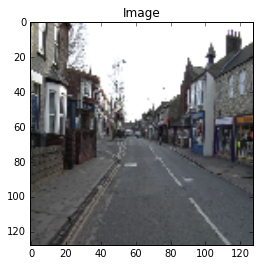

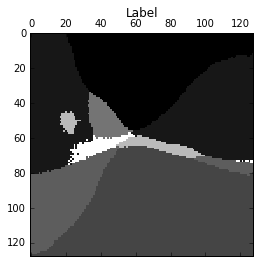

In [52]:
testIndex = 0
drawTestImageSet(testIndex, tmp_predmax[testIndex])

(128, 128), max: 11


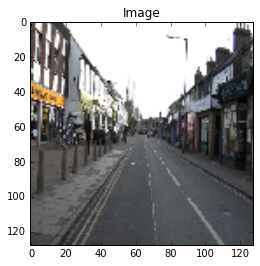

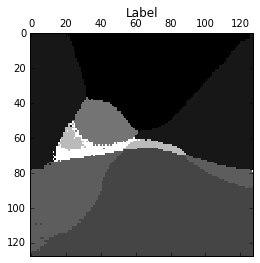

In [53]:
testIndex = 100
drawTestImageSet(testIndex, tmp_predmax[testIndex])

(128, 128), max: 11


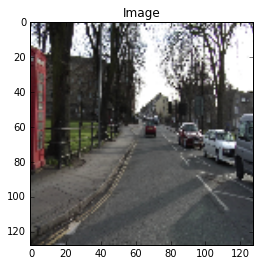

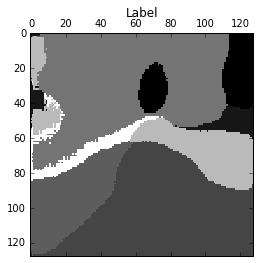

In [54]:
testIndex = 50
drawTestImageSet(testIndex, tmp_predmax[testIndex])

(128, 128), max: 11


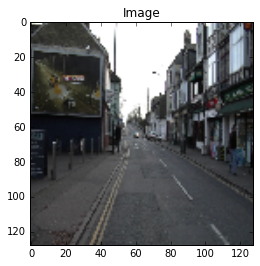

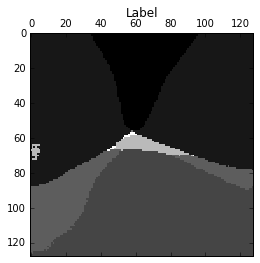

In [56]:
testIndex = 200
drawTestImageSet(testIndex, tmp_predmax[testIndex])

(128, 128), max: 11


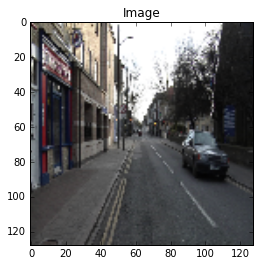

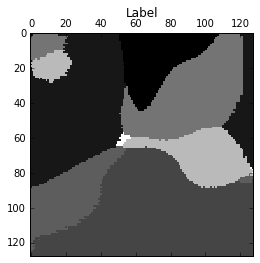

In [58]:
testIndex = 150
drawTestImageSet(testIndex, tmp_predmax[testIndex])

(128, 128), max: 11


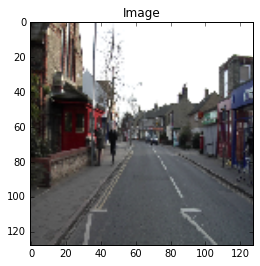

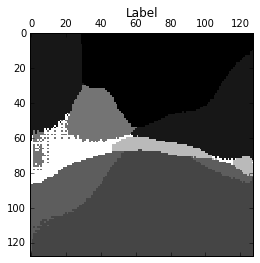

In [59]:
testIndex = 30
drawTestImageSet(testIndex, tmp_predmax[testIndex])

In [60]:
sess.close()

In [25]:
tmp_shape

[None, 128, 128, 22]

## Tensorflow Test

In [17]:
c = tf.constant([[[1,2,3,4], [-1,-2,-3,-4], [5,6,7,8], [1, 0, 0, 1]],
                [[11,12,13,14], [-11,-12,-13,-14], [15,16,17,18], [1, 20, 20, 1]]])

In [66]:
sess.run(c)[0]

array([[ 1,  2,  3,  4],
       [-1, -2, -3, -4],
       [ 5,  6,  7,  8],
       [ 1,  0,  0,  1]], dtype=int32)

In [ ]:
sess.run(c.get_shape().as_list())

In [67]:
sess.run(tf.argmax(c, 0))

array([[1, 1, 1, 1],
       [0, 0, 0, 0],
       [1, 1, 1, 1],
       [0, 1, 1, 0]])

In [68]:
# d = tf.constant(sess.run(c)[0])
tmp_c = sess.run(pool(c))

In [69]:
tmp_c

array([[[ 1,  2,  3,  4],
        [ 5,  6,  7,  8]],

       [[11, 12, 13, 14],
        [15, 16, 17, 18]]], dtype=int32)

In [70]:
c

<tf.Tensor 'Const_4:0' shape=(2, 4, 4) dtype=int32>

In [72]:
tmp_c = tf.constant(tmp_c)
tmp_c2 = sess.run(unpool(tmp_c))

In [73]:
tmp_c2

array([[[ 1,  2,  3,  4],
        [ 0,  0,  0,  0],
        [ 5,  6,  7,  8],
        [ 0,  0,  0,  0]],

       [[11, 12, 13, 14],
        [ 0,  0,  0,  0],
        [15, 16, 17, 18],
        [ 0,  0,  0,  0]]], dtype=int32)